In [1]:
import tensorflow as tf

import os
import pathlib
import time
import datetime
import numpy as np
from matplotlib import pyplot as plt
from IPython import display

In [2]:
#change current directory up to parent, only run 1 time!
os.chdir("..")

In [3]:
#encoder
def downsample(filters, size, apply_batchnorm=True):
  initializer = tf.random_normal_initializer(0., 0.02)

  result = tf.keras.Sequential()
  result.add(
      tf.keras.layers.Conv2D(filters, size, strides=2, padding='same',
                             kernel_initializer=initializer, use_bias=False))

  if apply_batchnorm:
    result.add(tf.keras.layers.BatchNormalization())

  result.add(tf.keras.layers.LeakyReLU())

  return result

In [4]:
down_model = downsample(3, 4)

In [5]:
#decoder
def upsample(filters, size, apply_dropout=False):
  initializer = tf.random_normal_initializer(0., 0.02)

  result = tf.keras.Sequential()
  result.add(
    tf.keras.layers.Conv2DTranspose(filters, size, strides=2,
                                    padding='same',
                                    kernel_initializer=initializer,
                                    use_bias=False))

  result.add(tf.keras.layers.BatchNormalization())

  if apply_dropout:
      result.add(tf.keras.layers.Dropout(0.5))

  result.add(tf.keras.layers.ReLU())

  return result

In [6]:
up_model = upsample(3, 4)
print(up_model)

In [29]:
def Generator():
  inputs = tf.keras.layers.Input(shape=[256, 256, 3])

  down_stack = [
    downsample(64, 4, apply_batchnorm=False),  # (batch_size, 128, 128, 64)
    downsample(128, 4),  # (batch_size, 64, 64, 128)
    downsample(256, 4),  # (batch_size, 32, 32, 256)
    downsample(512, 4),  # (batch_size, 16, 16, 512)
    downsample(512, 4),  # (batch_size, 8, 8, 512)
    downsample(512, 4),  # (batch_size, 4, 4, 512)
    downsample(512, 4),  # (batch_size, 2, 2, 512)
    downsample(512, 4),  # (batch_size, 1, 1, 512)
  ]

  up_stack = [
    upsample(512, 4, apply_dropout=True),  # (batch_size, 2, 2, 1024)
    upsample(512, 4, apply_dropout=True),  # (batch_size, 4, 4, 1024)
    upsample(512, 4, apply_dropout=True),  # (batch_size, 8, 8, 1024)
    upsample(512, 4),  # (batch_size, 16, 16, 1024)
    upsample(256, 4),  # (batch_size, 32, 32, 512)
    upsample(128, 4),  # (batch_size, 64, 64, 256)
    upsample(64, 4),  # (batch_size, 128, 128, 128)
  ]

  initializer = tf.random_normal_initializer(0., 0.02)
  OUTPUT_CHANNELS=1
  last = tf.keras.layers.Conv2DTranspose(OUTPUT_CHANNELS, 4,
                                         strides=2,
                                         padding='same',
                                         kernel_initializer=initializer,
                                         activation='tanh')  # (batch_size, 256, 256, 3)
  softlayer=tf.keras.layers.Softmax()

  x = inputs

  # Downsampling through the model
  skips = []
  for down in down_stack:
    x = down(x)
    skips.append(x)

  skips = reversed(skips[:-1])

  # Upsampling and establishing the skip connections
  for up, skip in zip(up_stack, skips):
    x = up(x)
    x = tf.keras.layers.Concatenate()([x, skip])

  x = last(x)
  
  #x = softlayer(x)
  return tf.keras.Model(inputs=inputs, outputs=x)

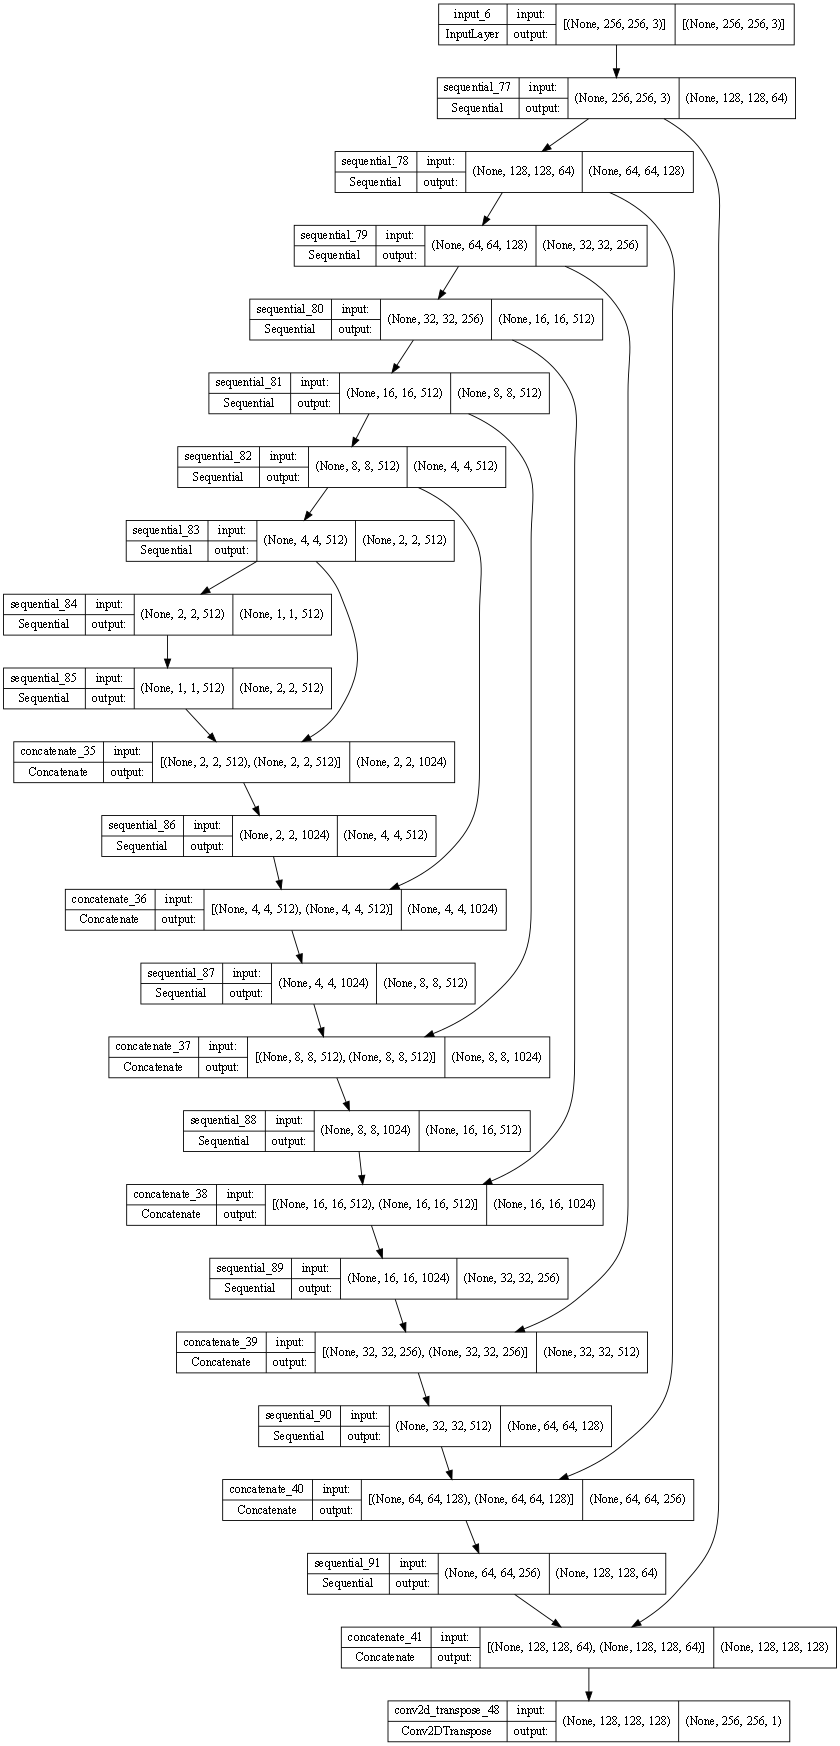

In [30]:
generator = Generator()
tf.keras.utils.plot_model(generator, show_shapes=True, dpi=64)

In [27]:
path1=f'{os.path.abspath(os.curdir)}/data/carseg_data/clean_data/5.npy'
test1=np.load(path1)
rgb1=test1[:3].transpose()
rgb1=tf.convert_to_tensor(rgb1)
r1=test1[3].transpose()
r1=tf.convert_to_tensor(r1)
print(rgb1.shape)
print(r1.shape)

(256, 256, 3)
(256, 256)


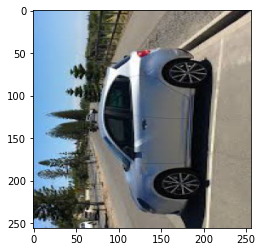

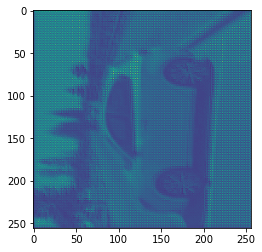

In [31]:
outt=generator(rgb1[tf.newaxis,...],training=False)
plt.imshow(rgb1)
plt.show()
plt.imshow(outt[0,...])
plt.show()

In [32]:
print(outt[0,...])

tf.Tensor(
[[[ 0.00227997]
  [ 0.01415275]
  [ 0.0261873 ]
  ...
  [ 0.00585352]
  [ 0.01555741]
  [ 0.00129055]]

 [[-0.01185478]
  [ 0.03087698]
  [ 0.01595257]
  ...
  [ 0.01256507]
  [ 0.00054019]
  [ 0.02664009]]

 [[ 0.01724202]
  [ 0.00615002]
  [ 0.04543767]
  ...
  [ 0.00362093]
  [ 0.03337513]
  [ 0.00511861]]

 ...

 [[-0.01478812]
  [ 0.00409792]
  [-0.00194311]
  ...
  [ 0.00662293]
  [-0.00460766]
  [ 0.01603833]]

 [[ 0.00594376]
  [-0.00056319]
  [ 0.0379414 ]
  ...
  [ 0.00803183]
  [ 0.03580166]
  [ 0.00367486]]

 [[ 0.00137166]
  [-0.0076825 ]
  [ 0.00310836]
  ...
  [ 0.0020477 ]
  [-0.00010658]
  [ 0.00349573]]], shape=(256, 256, 1), dtype=float32)


# loos

In [34]:
LAMBDA = 100

In [33]:
loss_object = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [35]:
def generator_loss(disc_generated_output, gen_output, target):
  gan_loss = loss_object(tf.ones_like(disc_generated_output), disc_generated_output)

  # Mean absolute error
  l1_loss = tf.reduce_mean(tf.abs(target - gen_output))

  total_gen_loss = gan_loss + (LAMBDA * l1_loss)

  return total_gen_loss, gan_loss, l1_loss